In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
#import mylib

Saving __init__.py to __init__.py
Saving bayesian_optimization.py to bayesian_optimization.py
Saving domain_reduction.py to domain_reduction.py
Saving event.py to event.py
Saving logger.py to logger.py
Saving observer.py to observer.py
Saving target_space.py to target_space.py
Saving util.py to util.py


372

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import os

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
from keras.optimizers import *
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, MaxPooling2D, Flatten, MaxPooling3D, Reshape, LSTM, TimeDistributed, MaxPooling1D
from tensorflow.keras.layers import ConvLSTM2D, Conv2D # problems with _long_ sequences: https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import EarlyStopping
#from bayesian_optimization import BayesianOptimization
from sklearn.model_selection import KFold
from timeit import timeit
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.backend import sqrt, square, mean
import random

In [ ]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
trainingDataRoot = '/content/drive/My Drive/Colab Notebooks/TrainingData'
#trainingFileList = [f for f in os.listdir(trainingDataRoot) if f.endswith('.npy') and os.path.isfile(os.path.join(trainingDataRoot, f))]

In [ ]:
# Create a list of fold names under taining folder 
trainingDataFolder = sorted( [ o for o in os.listdir( trainingDataRoot ) if os.path.isdir( os.path.join( trainingDataRoot, o ) )], reverse=False )
#trainingDataFolder

In [ ]:
# Create a list of training numpy array file names
trainingFileList = []
for i in trainingDataFolder:
  dayList = []
  for o in sorted( os.listdir(os.path.join(trainingDataRoot, i)) ):
    if o.endswith('.npy') and os.path.isfile( os.path.join( trainingDataRoot, i, o ) ):
      dayList.append(o)
  trainingFileList.append(dayList)
#trainingFileList

In [ ]:
import datetime

In [ ]:
# Create a list of dates for 2 days before the event
twoDayList = []
for i in trainingDataFolder:
  twoDay = datetime.datetime.strptime( i, '%Y-%m-%d' ) + datetime.timedelta( days=-2 )
  twoDaystr = '{:04}-{:02}-{:02}'.format( twoDay.year, twoDay.month, twoDay.day )
  twoDayList.append(twoDaystr)
#twoDayList

In [ ]:
# Create a list dates for 1 day before the event
oneDayList = []
for i in trainingDataFolder:
  oneDay = datetime.datetime.strptime( i, '%Y-%m-%d' ) + datetime.timedelta( days=-1 )
  oneDaystr = '{:04}-{:02}-{:02}'.format( oneDay.year, oneDay.month, oneDay.day )
  oneDayList.append(oneDaystr)
#oneDayList

In [ ]:
trainingData = []
trainingLabel = []
for i, j in enumerate( trainingDataFolder ):
  for m in range( len( trainingFileList[i] ) - 9 ):
    sequenceData = []
    validateData = []
    for n in range ( 10 ):
      with open( os.path.join(trainingDataRoot, j, trainingFileList[i][m +n] ), 'rb' ) as f:
        sequenceData.append( list( np.load( f ) ) )
        validateData.append(os.path.splitext( trainingFileList[i][m +n] )[0] )
        #print( f'validateData:{validateData} {i, m +n}' )
    trainingData.append( sequenceData )
    if validateData[-1] in trainingDataFolder:
      trainingLabel.append( 0.4 )
    elif validateData[-1] in oneDayList or validateData[-2] in trainingDataFolder:
      trainingLabel.append( 0.25 )
    elif validateData[-1] in twoDayList or validateData[-3] in trainingDataFolder:
      trainingLabel.append( 0.05 )
    else:
      trainingLabel.append(0)
train_X = np.array( trainingData, dtype=np.float32 )
print( train_X.shape )
train_y = np.array( trainingLabel, dtype=np.float32 )
print( train_y.shape )

(390, 10, 50, 50, 3)
(390,)


In [ ]:
train_y

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05,
       0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25,
       0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 ,
       0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25,
       0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.

In [ ]:
testDataRoot = '/content/drive/My Drive/Colab Notebooks/TestData'
#testFileList = [f for f in os.listdir(testDataRoot) if f.endswith('.npy') and os.path.isfile(os.path.join(testDataRoot, f))]

In [ ]:
testDataFolder = sorted( [ o for o in os.listdir( testDataRoot ) if os.path.isdir( os.path.join( testDataRoot, o ) )], reverse=False )
testDataFolder

['2013-12-16', '2015-05-04', '2017-10-22']

In [ ]:
testFileList = []
for i in testDataFolder:
  dayList = []
  for o in sorted( os.listdir( os.path.join(testDataRoot, i ) ) ):
    if o.endswith( '.npy' ) and os.path.isfile( os.path.join( testDataRoot, i, o ) ):
      dayList.append( o )
  testFileList.append( dayList )
testFileList

[['2013-11-25.npy',
  '2013-11-26.npy',
  '2013-11-27.npy',
  '2013-11-28.npy',
  '2013-11-29.npy',
  '2013-11-30.npy',
  '2013-12-01.npy',
  '2013-12-02.npy',
  '2013-12-03.npy',
  '2013-12-04.npy',
  '2013-12-05.npy',
  '2013-12-06.npy',
  '2013-12-07.npy',
  '2013-12-08.npy',
  '2013-12-09.npy',
  '2013-12-10.npy',
  '2013-12-11.npy',
  '2013-12-12.npy',
  '2013-12-13.npy',
  '2013-12-14.npy',
  '2013-12-15.npy',
  '2013-12-16.npy',
  '2013-12-17.npy',
  '2013-12-18.npy'],
 ['2015-04-13.npy',
  '2015-04-14.npy',
  '2015-04-15.npy',
  '2015-04-16.npy',
  '2015-04-17.npy',
  '2015-04-18.npy',
  '2015-04-19.npy',
  '2015-04-20.npy',
  '2015-04-21.npy',
  '2015-04-22.npy',
  '2015-04-23.npy',
  '2015-04-24.npy',
  '2015-04-25.npy',
  '2015-04-26.npy',
  '2015-04-27.npy',
  '2015-04-28.npy',
  '2015-04-29.npy',
  '2015-04-30.npy',
  '2015-05-01.npy',
  '2015-05-02.npy',
  '2015-05-03.npy',
  '2015-05-04.npy',
  '2015-05-05.npy',
  '2015-05-06.npy'],
 ['2017-10-01.npy',
  '2017-10-02.npy'

In [ ]:
testData = []
testLabel = []
for i, j in enumerate( testDataFolder ):
  for m in range( len( testFileList[i] ) - 9 ):
    sequenceData = []
    validateData = []
    for n in range ( 10 ):
      with open( os.path.join( testDataRoot, j, testFileList[i][m +n] ), 'rb') as f:
        sequenceData.append( list( np.load( f ) ) )
        validateData.append( os.path.splitext( testFileList[i][m +n] )[0] )
        #print( f'validateData:{validateData} {i, m +n}' )
    testData.append( sequenceData )
    twoDay = datetime.datetime.strptime( j, '%Y-%m-%d' ) + datetime.timedelta( days=-2 )
    twoDaystr = '{:04}-{:02}-{:02}'.format( twoDay.year, twoDay.month, twoDay.day )
    oneDay = datetime.datetime.strptime( j, '%Y-%m-%d' ) + datetime.timedelta( days=-1 )
    oneDaystr = '{:04}-{:02}-{:02}'.format( oneDay.year, oneDay.month, oneDay.day )
    if validateData[-1] == j:
      testLabel.append( 0.4 )
    elif validateData[-1] == twoDaystr or validateData[-3] == j:
      testLabel.append( 0.05 )
    elif validateData[-1] == oneDaystr or validateData[-2] == j:
      testLabel.append( 0.25 )
    else:
      testLabel.append(0)
test_X = np.array( testData, dtype=np.float32 )
print( test_X.shape )
test_y = np.array( testLabel, dtype=np.float32 )
print( test_y.shape )

(45, 10, 50, 50, 3)
(45,)


In [ ]:
test_y

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05,
       0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25,
       0.05], dtype=float32)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# label encode the target variable
y = LabelEncoder().fit_transform(train_y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=248 (63.590%)
Class=1, n=56 (14.359%)
Class=2, n=57 (14.615%)
Class=3, n=29 (7.436%)


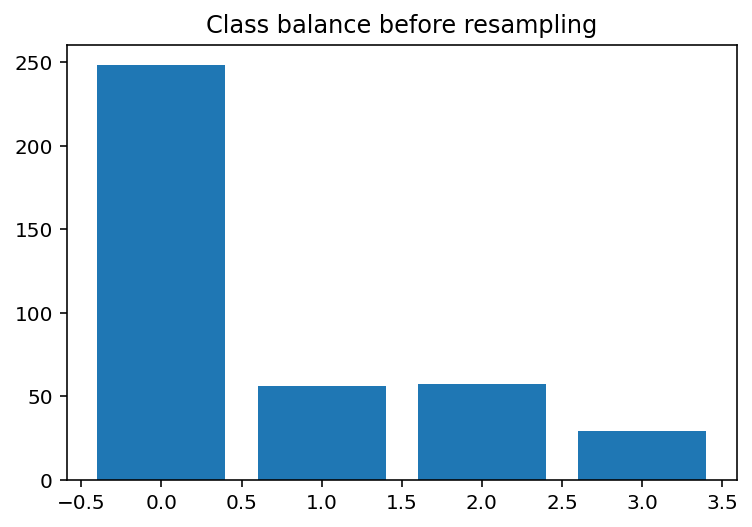

In [ ]:
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.title("Class balance before resampling")
plt.show()

In [ ]:
orig_shape = train_X.shape
print(orig_shape)

(390, 10, 50, 50, 3)


In [ ]:
train2D_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1] * train_X.shape[2] * train_X.shape[3] * train_X.shape[4]))
print(train2D_X.shape)

(390, 75000)


Class=0, n=248 (25.000%)
Class=1, n=248 (25.000%)
Class=2, n=248 (25.000%)
Class=3, n=248 (25.000%)


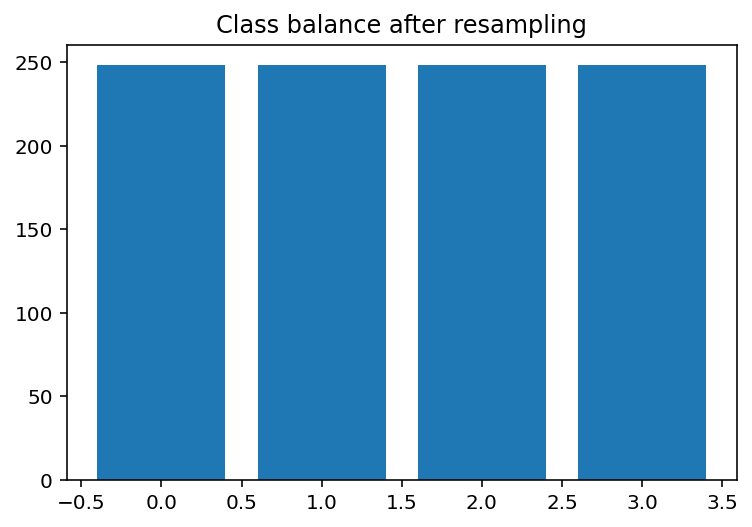

In [ ]:
from imblearn.over_sampling import SMOTE
y = LabelEncoder().fit_transform(train_y)
# transform the dataset
oversample = SMOTE()
new_train_X, new_train_y = oversample.fit_resample(train2D_X, y)
# summarize distribution
counter = Counter(new_train_y)
for k,v in counter.items():
	per = v / len(new_train_y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.title("Class balance after resampling")
plt.show()

In [ ]:
new_train_y = new_train_y.astype(np.float)
reg_dict = {0:0, 1:0.05, 2:0.25, 3:0.4}
for i in range(len(new_train_y)):
  new_train_y[i] = reg_dict[new_train_y[i]]

In [ ]:
new_train_y

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05,
       0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25,
       0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 ,
       0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25,
       0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.

In [ ]:
new_shape = ( new_train_X.shape[0], train_X.shape[1], train_X.shape[2], train_X.shape[3], train_X.shape[4] )
new_train_X = np.reshape(new_train_X, new_shape)
print(new_train_X.shape)

(992, 10, 50, 50, 3)


In [ ]:
new_train_y.shape

(992,)

In [ ]:
training_image_size = ( train_X.shape[1], train_X.shape[2], train_X.shape[3], train_X.shape[4] )
print( training_image_size )

(10, 50, 50, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


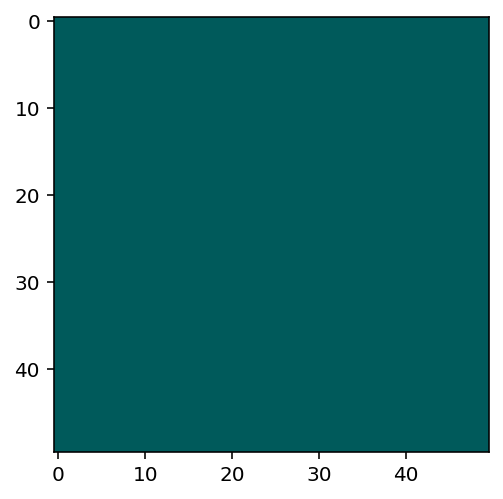

In [ ]:
plt.imshow(new_train_X[0][0])

In [ ]:
random.seed(4)
new_train_X, new_train_y = shuffle(new_train_X, new_train_y)

In [ ]:
new_train_y

array([0.4 , 0.05, 0.25, 0.25, 0.05, 0.25, 0.4 , 0.4 , 0.  , 0.  , 0.4 ,
       0.05, 0.05, 0.05, 0.4 , 0.  , 0.25, 0.  , 0.  , 0.25, 0.05, 0.  ,
       0.25, 0.4 , 0.05, 0.4 , 0.05, 0.4 , 0.05, 0.05, 0.4 , 0.05, 0.25,
       0.05, 0.25, 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.  , 0.  , 0.05,
       0.25, 0.4 , 0.4 , 0.25, 0.05, 0.05, 0.25, 0.05, 0.05, 0.25, 0.25,
       0.4 , 0.4 , 0.  , 0.4 , 0.05, 0.05, 0.  , 0.  , 0.05, 0.25, 0.25,
       0.4 , 0.  , 0.4 , 0.4 , 0.05, 0.4 , 0.4 , 0.05, 0.05, 0.  , 0.4 ,
       0.25, 0.25, 0.4 , 0.05, 0.4 , 0.05, 0.4 , 0.4 , 0.4 , 0.05, 0.25,
       0.25, 0.05, 0.4 , 0.4 , 0.  , 0.  , 0.05, 0.05, 0.4 , 0.  , 0.4 ,
       0.05, 0.25, 0.25, 0.4 , 0.05, 0.25, 0.25, 0.25, 0.25, 0.05, 0.25,
       0.25, 0.4 , 0.4 , 0.25, 0.4 , 0.  , 0.  , 0.25, 0.05, 0.05, 0.4 ,
       0.05, 0.25, 0.  , 0.25, 0.05, 0.25, 0.  , 0.25, 0.05, 0.  , 0.25,
       0.  , 0.05, 0.4 , 0.4 , 0.05, 0.25, 0.05, 0.4 , 0.05, 0.4 , 0.4 ,
       0.  , 0.  , 0.25, 0.05, 0.  , 0.05, 0.05, 0.

In [ ]:
def build_convnet( neurons=2, kernels=4, layers=3 ): #shrink=1
  model = Sequential()
  neurons = int( neurons )
  kernels = int( kernels )
  layers = int( layers )
  kernel = int( kernels *2 +1 )
  #neuronsLevel = neurons
  model.add(ConvLSTM2D( 16 *neurons, (kernel, kernel), name='base',activation='relu', padding='same', return_sequences=True, 
                       input_shape = training_image_size, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  model.add(Dropout(0.1))
  for i in range( layers ):
    #neuronsLevel *= shrink
    model.add(ConvLSTM2D( 16 *neurons, (kernel, kernel), name=f'multiple{i}', activation='relu', padding='same', return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Dropout(0.1))
  
  #neuronsLevel *= shrink
  model.add(ConvLSTM2D( 16 *neurons, (kernel, kernel), name='dim_reduce', activation='relu', padding='same', return_sequences=False))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(1, 2)))
  model.add(Dropout(0.1))
  #model.add(Conv2D( 8 *neurons, (7, 7), activation='relu', padding='same'))
  #model.add(BatchNormalization())
  #model.add(MaxPooling2D(pool_size=(1, 2)))
  #model.add(Dropout(0.1))
  #model.add(TimeDistributed(Flatten()))
  #model.add(LSTM(32, return_sequences=True))
  #model.add(Dropout(0.1))
  #model.add(LSTM(32, return_sequences=True))
  #model.add(Dropout(0.1))
  model.add(Dense(320, activation='relu'))
  model.add(Dropout(0.1))
  #model.add(Dense(640, activation='relu'))
  #model.add(Dropout(0.1))

  model.add(Flatten())
  
  #model.add(Dense(256, activation='relu'))
  
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='relu'))


  #out_shape = model.output_shape
  #SequenceLength = train_X.shape[1]
  #model.add(Reshape((SequenceLength, out_shape[1])))
  #model.add(LSTM(64, return_sequences=False))
  #model.add(Dropout(0.5))
  #model.add(Dense(1, activation='relu'))
  
  model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])

  
 
  # model structure summary
  return model

model = build_convnet()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base (ConvLSTM2D)            (None, 10, 50, 50, 32)    363008    
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 10, 25, 25, 32)    0         
_________________________________________________________________
multiple0 (ConvLSTM2D)       (None, 10, 25, 25, 32)    663680    
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 10, 12, 12, 32)    0         
_________________________________________________________________
multiple1 (ConvLSTM2D)       (None, 10, 12, 12, 32)    663680    
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 10, 6, 6, 32)      0         
_________________________________________________________________
dim_reduce (ConvLSTM2D)      (None, 6, 6, 32)         

In [ ]:
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])

In [ ]:
print(new_train_X.shape)
print(new_train_y.shape)
print(test_X.shape)
print(test_y.shape)

(992, 10, 50, 50, 3)
(992,)
(45, 10, 50, 50, 3)
(45,)


In [ ]:
def build_convnet( neurons=2, kernels=4, layers=0 ): #shrink=1
  model = Sequential()
  neurons = int( neurons )
  kernels = int( kernels )
  layers = int( layers )
  kernel = int( kernels *2 +1 )
  #neuronsLevel = neurons
  model.add(ConvLSTM2D( 16 *neurons, (kernel, kernel), name='base',activation='relu', padding='same', return_sequences=True, 
                       input_shape = training_image_size, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  model.add(Dropout(0.1))
  for i in range( layers ):
    #neuronsLevel *= shrink
    model.add(ConvLSTM2D( 16 *neurons, (kernel, kernel), name=f'multiple{i}', activation='relu', padding='same', return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Dropout(0.1))
  
  #neuronsLevel *= shrink
  model.add(ConvLSTM2D( 16 *neurons, (kernel, kernel), name='dim_reduce', activation='relu', padding='same', return_sequences=False))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(1, 2)))
  model.add(Dropout(0.1))
  model.add(Conv2D( 8 *neurons, (7, 7), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(1, 2)))
  model.add(Dropout(0.1))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32, return_sequences=True))
  model.add(Dropout(0.1))
  model.add(LSTM(32, return_sequences=True))
  model.add(Dropout(0.1))
  model.add(Dense(960, activation='relu'))
  model.add(Dropout(0.1))
  #model.add(Dense(320, activation='relu'))
  #model.add(Dropout(0.1))

  model.add(Flatten())
  
  #model.add(Dense(256, activation='relu'))
  
  model.add(Dense(640, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='relu'))


  #out_shape = model.output_shape
  #SequenceLength = train_X.shape[1]
  #model.add(Reshape((SequenceLength, out_shape[1])))
  #model.add(LSTM(64, return_sequences=False))
  #model.add(Dropout(0.5))
  #model.add(Dense(1, activation='relu'))
  
  model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])

  
 
  # model structure summary
  return model

model = build_convnet()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base (ConvLSTM2D)            (None, 10, 50, 50, 32)    363008    
_________________________________________________________________
batch_normalization_22 (Batc (None, 10, 50, 50, 32)    128       
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 10, 25, 25, 32)    0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 10, 25, 25, 32)    0         
_________________________________________________________________
dim_reduce (ConvLSTM2D)      (None, 25, 25, 32)        663680    
_________________________________________________________________
batch_normalization_23 (Batc (None, 25, 25, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 12, 32)      

In [ ]:
earlyStopping = EarlyStopping( monitor='val_loss', min_delta=1.0e-4, patience=50, verbose=2, mode='auto' )
callbacks = [earlyStopping]
history = model.fit(new_train_X, new_train_y, batch_size=10, epochs=50, verbose=True, validation_split=0.1, callbacks=callbacks, shuffle=False)
loss, accuracy  = model.evaluate(test_X, test_y, verbose=False)
model.predict( test_X ).max()

Epoch 1/50


KeyboardInterrupt: ignored

In [ ]:
a = zip(model.predict( test_X ), test_y )
print("  predict    label")
for i, j in a:
  print('%.8f   %.02f'% (float(i), j))

  predict    label
0.42830524   0.00
0.40208927   0.00
0.25921026   0.00
0.23544948   0.00
0.16623828   0.00
0.10382523   0.00
0.08563825   0.00
0.14925991   0.00
0.18435369   0.00
0.18159090   0.00
0.17576075   0.05
0.17711119   0.25
0.12762155   0.40
0.05452364   0.25
0.09451210   0.05
0.13383123   0.00
0.15465394   0.00
0.15482044   0.00
0.10525435   0.00
0.07693005   0.00
0.08032775   0.00
0.05939143   0.00
0.04161147   0.00
0.01380051   0.00
0.04808924   0.00
0.23439899   0.05
0.36551246   0.25
0.38445979   0.40
0.32863122   0.25
0.13301262   0.05
0.14825824   0.00
0.14283630   0.00
0.13724791   0.00
0.13028267   0.00
0.12827726   0.00
0.12790915   0.00
0.12854522   0.00
0.13466062   0.00
0.14476876   0.00
0.14243361   0.00
0.13981411   0.05
0.13867715   0.25
0.14061929   0.40
0.14940846   0.25
0.19959268   0.05


In [ ]:
d = {'pred': list(model.predict( test_X )), 'test': test_y}
performance = pd.DataFrame(data=d)
for i in range(len(performance['pred'])):
  performance['pred'][i] = performance['pred'][i][0]

<Figure size 576x432 with 0 Axes>

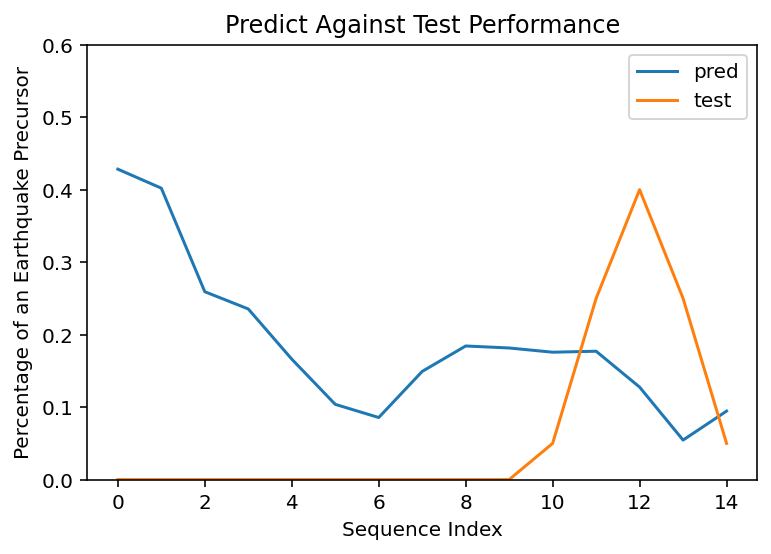

<Figure size 576x432 with 0 Axes>

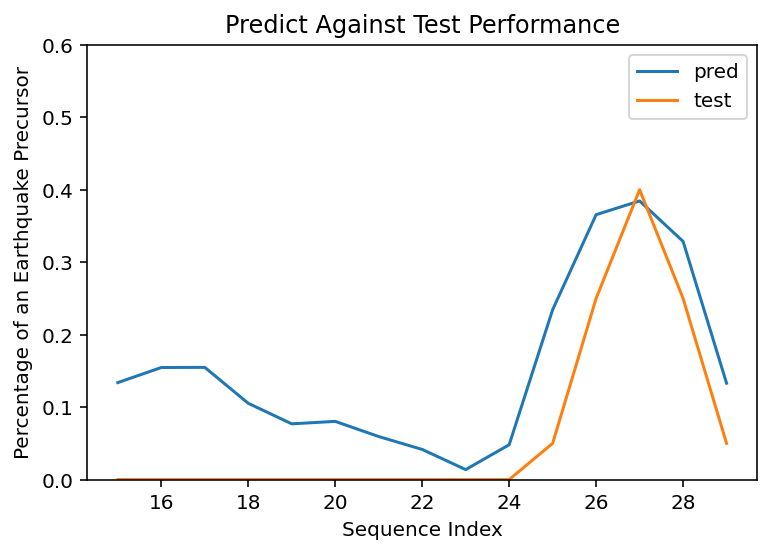

<Figure size 576x432 with 0 Axes>

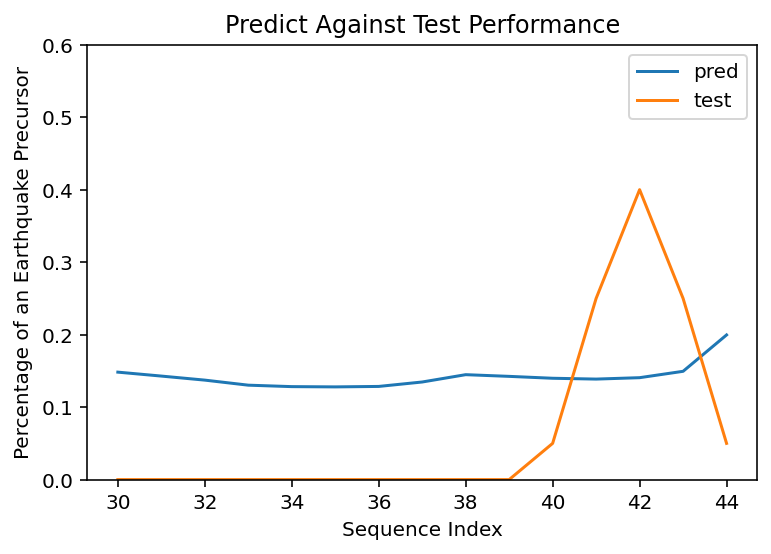

In [ ]:
historydf = pd.DataFrame( performance )
for i in range( int(len(historydf) / 15 ) ):
  plt.figure(figsize=(8, 6))
  historydf[(0 + (i * 15)) : (15 + (i * 15))].plot(ylim=(0, max(0.6, historydf[(0 + (i * 15)) : (15 + (i * 15))].values.max())))
  plt.xlabel('Sequence Index')
  plt.ylabel('Percentage of an Earthquake Precursor')
  plt.title('Predict Against Test Performance')

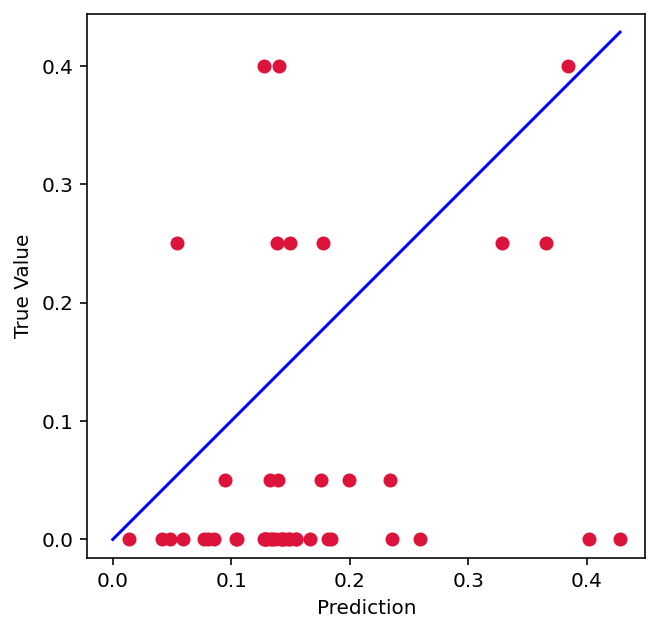

In [ ]:
predicted_value = model.predict( test_X )
true_value = test_y

plt.figure(figsize=(5,5))
plt.scatter(predicted_value, true_value, c='crimson')
plt.yscale('linear')
plt.xscale('linear')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.axis('equal')
plt.show()

Test loss: 0.0267
Test accuracy: 0.667


<Figure size 576x432 with 0 Axes>

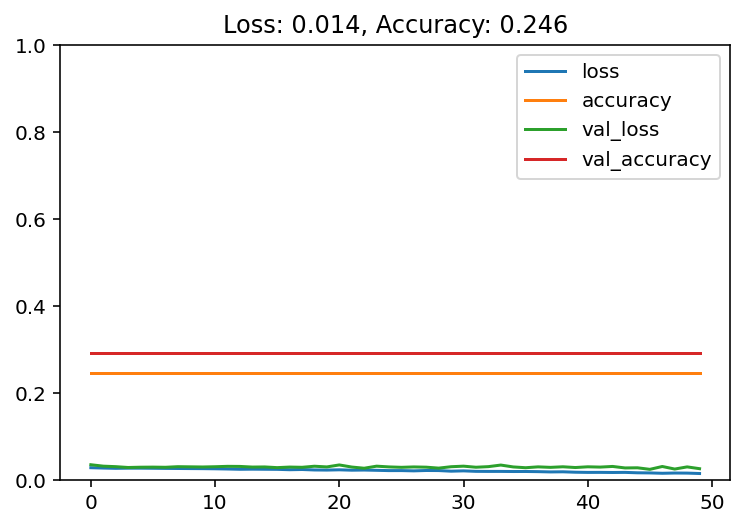

In [ ]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [ ]:
history.history

{'accuracy': [0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262,
  0.2466367781162262],
 'loss': [0.028344232589006424,
  0.02758735790848732,
  0.027602482587099075,
  0.0273360013961792,
  0.027092307806015015,
  0.027068493887782097,
  0.02681375853717327,
  0.026165731251239777,
  0.02607637457549572,
  0.0259931068867445,
  0.025939403101801872,
  0.02519610896706581,
  0.025528427213430405,
  0.02501179836690426,
  0.025335971266031265,
  0.024726811796426773,
  0.02455788105726242],
 'val_accuracy': [0.2800000011920929,
  0.2800000011920929,
  0.2800000011920929,
  0.2800000011920929,
  0.2800000011920929,
  0.2800000011920929,
  0.2800000011920929,
  0.2800000011920929,
  0.2800000011

In [ ]:
def modelFit():
  earlyStopping = EarlyStopping( monitor='val_loss', min_delta=1.0e-4, patience=5, verbose=2, mode='auto' )
  callbacks = [earlyStopping]
  history = model.fit(train_X, train_y, batch_size=4, epochs=100, verbose=True, validation_data=( test_X, test_y ), callbacks=callbacks, shuffle=False)
  loss, accuracy  = model.evaluate(test_X, test_y, verbose=False)
  return model.predict( test_X ).max()

In [ ]:
def modeltests( **kwargs ):
#  return math.sqrt( kwargs['layers']) *math.sin( kwargs['neurons'])
  model = build_convnet( **kwargs )
  if model:
    result = modelFit()
    return float(result)

In [ ]:
pbounds = { 'layers': ( 0, 4 ), # number of "return_sequences=True" ConvLSTM layers
					'neurons': ( 1, 4 ), # all layers have this number of neurons (at present)
					'kernels': ( 1, 5 ) # int( kernel ) *2 +1 - odd numbers 3, 5, 7, 9, &c.
          'shrink': (0.1, 1)
          }
optimizer = BayesianOptimization(
					f=modeltests,
					pbounds=pbounds,
					verbose=10,
					random_state=42
					)
optimizer.maximize( init_points=12, n_iter=8 )
optimizer.max

In [ ]:
optimizer.max

In [ ]:
def printModel( model, filename ):
		try:
			print( model.summary())
			plot_model( model, to_file=filename, show_shapes=True )
		except ValueError as ex:
			print( '\nUnable to print model summary:{}\n'.format( ex ))
			return
		except ImportError as ex:
			print( '\nUnable  to print model:{}\n'.format( ex ))

In [ ]:
printModel(model, '/content/drive/My Drive/Colab Notebooks/PETA_CNN1.png')

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base (ConvLSTM2D)            (None, 10, 50, 50, 32)    363008    
_________________________________________________________________
batch_normalization_49 (Batc (None, 10, 50, 50, 32)    128       
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 10, 25, 25, 32)    0         
_________________________________________________________________
dropout_120 (Dropout)        (None, 10, 25, 25, 32)    0         
_________________________________________________________________
dim_reduce (ConvLSTM2D)      (None, 25, 25, 32)        663680    
_________________________________________________________________
batch_normalization_50 (Batc (None, 25, 25, 32)        128       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 25, 12, 32)      

In [ ]:
# evaluate the model
scores = model.evaluate(test_X, test_y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 66.67%


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/Colab Notebooks/model3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Colab Notebooks/model3.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('/content/drive/My Drive/Colab Notebooks/model4.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/Colab Notebooks/model4.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
score = loaded_model.evaluate(test_X, test_y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 66.67%


In [ ]:
loaded_model.predict(test_X)

array([[0.2125965 ],
       [0.2133804 ],
       [0.20447823],
       [0.18532157],
       [0.16988236],
       [0.15159757],
       [0.13548422],
       [0.14584696],
       [0.17435728],
       [0.17966834],
       [0.18151343],
       [0.1574009 ],
       [0.10962615],
       [0.00734554],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.15859094],
       [0.22008817],
       [0.22661358],
       [0.22147408],
       [0.1112818 ],
       [0.10885906],
       [0.11427777],
       [0.11395241],
       [0.1056474 ],
       [0.09828348],
       [0.09616184],
       [0.11404972],
       [0.12895015],
       [0.15051454],
       [0.16945785],
       [0.18496564],
       [0.19787908],
       [0.20868737],
       [0.2164089 ]], dtype=float32)

In [ ]:
d = {'pred': list(loaded_model.predict( test_X )), 'test': test_y}
performance = pd.DataFrame(data=d)
for i in range(len(performance['pred'])):
  performance['pred'][i] = performance['pred'][i][0]

<Figure size 576x432 with 0 Axes>

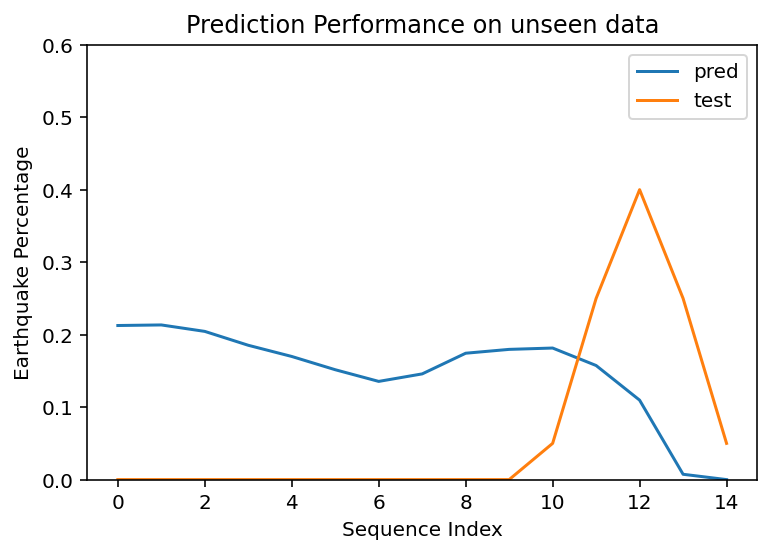

<Figure size 576x432 with 0 Axes>

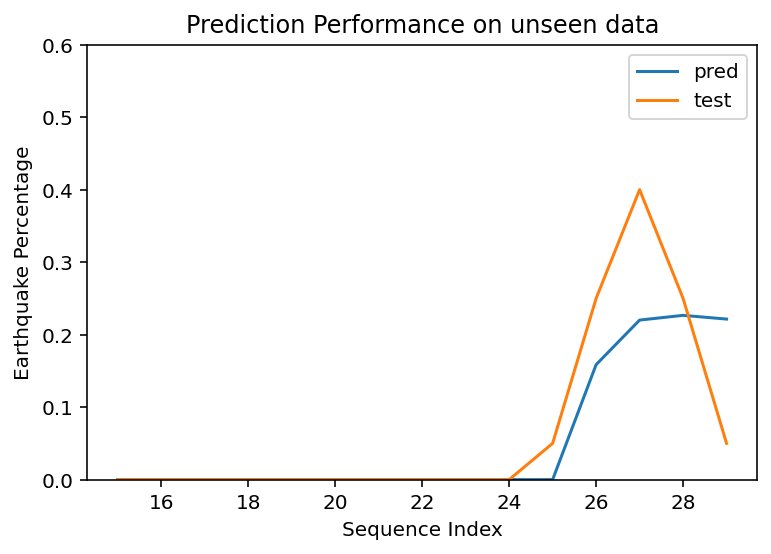

<Figure size 576x432 with 0 Axes>

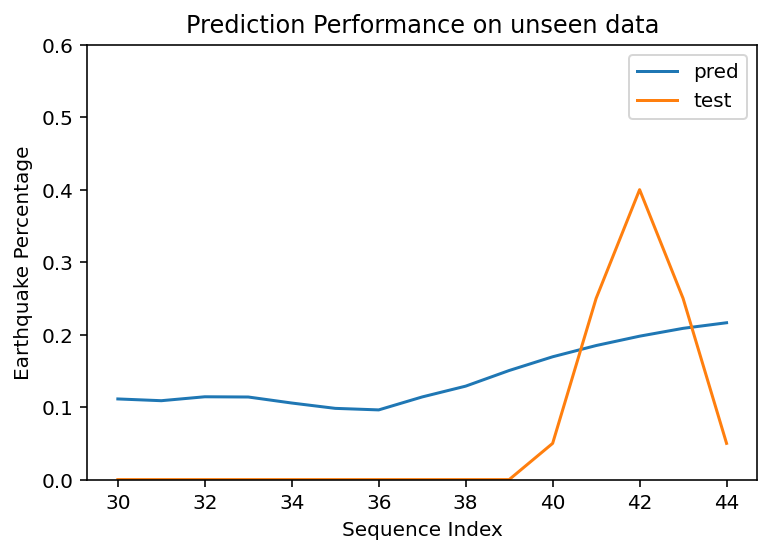

In [ ]:
historydf = pd.DataFrame( performance )
for i in range( int(len(historydf) / 15 ) ):
  plt.figure(figsize=(8, 6))
  historydf[(0 + (i * 15)) : (15 + (i * 15))].plot(ylim=(0, max(0.6, historydf[(0 + (i * 15)) : (15 + (i * 15))].values.max())))
  plt.xlabel('Sequence Index')
  plt.ylabel('Earthquake Percentage')
  plt.title('Prediction Performance on unseen data')

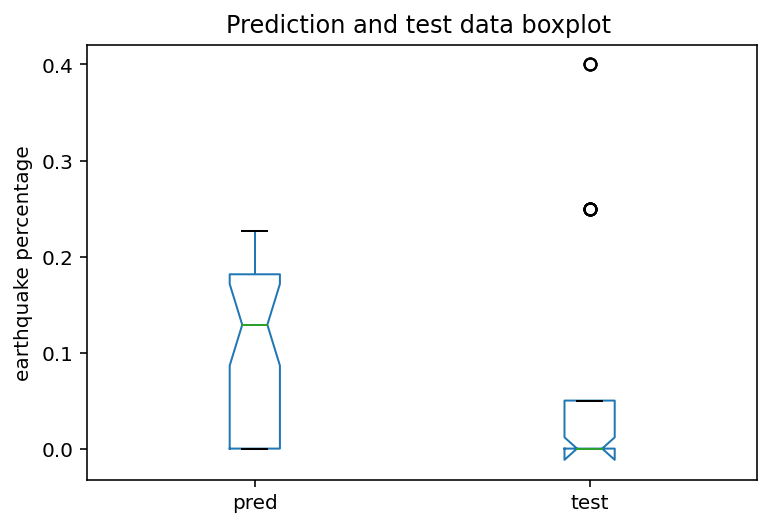

In [ ]:
performance.plot.box(title="Prediction and test data boxplot ", notch=True, ylabel="earthquake percentage")

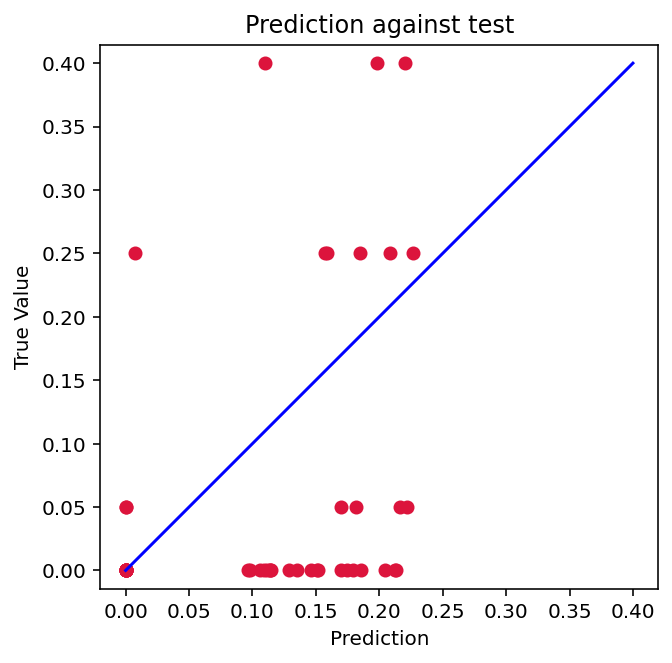

In [ ]:
predicted_value = loaded_model.predict( test_X )
true_value = test_y

plt.figure(figsize=(5,5))
plt.scatter(predicted_value, true_value, c='crimson')
plt.yscale('linear')
plt.xscale('linear')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.axis('equal')
plt.title('Prediction against test')
plt.show()